This script identifies cluster-sex-specific diseases, extracts their p-values from the full dataset,  
and generates Miami plots to visualize statistical significance.

Key steps:
1. **Identify cluster-sex-specific diseases**: Filter comorbidities uniquely associated with each cluster.  
   - **Input:** `Data/upset_AD_positive_ICD10_female/male.csv`, `Data/upset_AD_negative_ICD10_female/male.csv`
2. **Extract p-values**: Retrieve corresponding p-values from the full dataset.  
   - **Input:** `Data/volcano_c{i}_other_ICD10_female/male.pickle`
3. **Generate Miami plots**: Visualize log-transformed p-values to highlight significant associations.

The output helps in identifying key comorbidities specific to each cluster and sex group.


In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import chi2_contingency
import scipy.stats as stats
from math import log10, log2

In [2]:
%run -i setupfunc.py

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load Female Datasets

In [4]:
# volcano_c1_other.pickle

# Prepare a dictionary to store file names and data
data_dict_f = {}

# Loop through files from c0 to c4, read them, and add a 'Cluster' column
for i in range(5):
    file_name = f'Data/volcano_c{i}_other_ICD10_female.pickle'  # Define the file name

    with open(file_name, 'rb') as file:
        data = pickle.load(file)  # Load the pickle file
        
        # Convert the 'ICD10' data into a DataFrame
        df = pd.DataFrame(data['ICD10'])  
        
        # Add a 'Cluster' column with the corresponding cluster number
        df['Cluster'] = i  

        # Store the DataFrame in the dictionary
        data_dict_f[f'c{i}'] = df  


In [5]:
# Concatenate all DataFrames in the dictionary vertically
combined_df_f = pd.concat(data_dict_f.values(), ignore_index=False)

In [6]:
df_f = combined_df_f[['-log_pvalue','pvalue','OddsRatio','Cluster']]

# Load Male Datasets

In [7]:
# Prepare a dictionary to store file names and data
data_dict_m = {}

# Loop through files from c0 to c4, read them, and add a 'Cluster' column
for i in range(5):
    file_name = f'Data/volcano_c{i}_other_ICD10_male.pickle'  # Define the file name

    with open(file_name, 'rb') as file:
        data = pickle.load(file)  # Load the pickle file
        
        # Convert the 'ICD10' data into a DataFrame
        df = pd.DataFrame(data['ICD10'])  
        
        # Add a 'Cluster' column with the corresponding cluster number
        df['Cluster'] = i  

        # Store the DataFrame in the dictionary
        data_dict_m[f'c{i}'] = df  

In [8]:
# Concatenate all DataFrames in the dictionary vertically
combined_df_m = pd.concat(data_dict_m.values(), ignore_index=False)

In [9]:
df_m = combined_df_m[['-log_pvalue','pvalue','OddsRatio','Cluster']]

# Merge female and male dataset

In [10]:
df_m = df_m.reset_index()
df_f = df_f.reset_index()

In [11]:
df_m.rename(columns={'-log_pvalue': '-log_pvalue_m', 'pvalue': 'pvalue_m', 'OddsRatio': 'OddsRatio_m'}, inplace=True)
df_f.rename(columns={'-log_pvalue': '-log_pvalue_f', 'pvalue': 'pvalue_f', 'OddsRatio': 'OddsRatio_f'}, inplace=True)

In [12]:
# Merge female and male dataset
data = pd.merge(df_m, df_f, on=['ICD10', 'Cluster'], how='outer')

In [13]:
data = data.reset_index()

In [14]:
data['ICD10_chape'] = data['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [15]:
data['ICD10_chape_name'] = data['ICD10_chape'].apply(lambda x: ICDchapter_to_name(x))

In [16]:
# Remove records containing 'IMO' in the 'ICD10' column
data = data[~data['ICD10'].str.contains('IMO', na=False)]

In [17]:
# Sort the DataFrame by ICD-10 codes
data = data.sort_values(by='ICD10_chape')

In [18]:
data.head(3)

,index,ICD10,-log_pvalue_m,pvalue_m,OddsRatio_m,Cluster,-log_pvalue_f,pvalue_f,OddsRatio_f,ICD10_chape,ICD10_chape_name
24457,24457,B19.11,1.002733,0.099373,75.457338,3,NaN,NaN,NaN,A00–B99,Infectious
24663,24663,A49.2,0.465704,0.342213,3.027778,3,-0.000000,1.000000,0.0,A00–B99,Infectious
36615,36615,A59.9,NaN,NaN,NaN,0,0.388643,0.408655,0.0,A00–B99,Infectious


# Make ICD10 list of cluster-specific comorbidities

In [19]:
positive_f = pd.read_csv('Data/upset_AD_positive_ICD10_female.csv')
positive_m = pd.read_csv('Data/upset_AD_positive_ICD10_male.csv')

In [20]:
positive_f['sum'] = positive_f[['c0', 'c1', 'c2', 'c3', 'c4']].sum(axis=1)
positive_m['sum'] = positive_m[['c0', 'c1', 'c2', 'c3', 'c4']].sum(axis=1)

In [21]:
positive_f = positive_f[positive_f['sum']==1]
positive_m = positive_m[positive_m['sum']==1]

In [22]:
negative_f = pd.read_csv('Data/upset_AD_negative_ICD10_female.csv')
negative_m = pd.read_csv('Data/upset_AD_negative_ICD10_male.csv')

In [23]:
negative_f['sum'] = negative_f[['c0', 'c3', 'c4']].sum(axis=1)
negative_m['sum'] = negative_m[['c0', 'c3', 'c4']].sum(axis=1)

In [24]:
negative_f = negative_f[negative_f['sum']==1]
negative_m = negative_m[negative_m['sum']==1]

In [25]:
specific_icd = pd.concat([positive_f,positive_m,  negative_m, negative_f], axis=0, ignore_index=True)

In [26]:
specific_icd

,Unnamed: 0,c0,c1,c2,c3,c4,ICD,sum
0,0,True,False,False,False,False,G31.01,1
1,2,False,True,False,False,False,A09,1
2,3,False,True,False,False,False,A41.50,1
3,6,False,True,False,False,False,A49.9,1
4,7,False,True,False,False,False,A60.00,1
...,...,...,...,...,...,...,...,...
3603,1196,True,NaN,NaN,False,False,Z99.81,1
3604,1197,False,NaN,NaN,False,True,F41.8,1
3605,1198,False,NaN,NaN,False,True,R46.89,1
3606,1199,False,NaN,NaN,False,True,Z00.6,1


In [27]:
# Convert columns c0-c4 to object (string) type
columns_to_convert = ['c0', 'c1', 'c2', 'c3', 'c4']
specific_icd[columns_to_convert] = specific_icd[columns_to_convert].astype(str)

# Miami Plot

In [28]:
category_color_mapping = {
    'A00–B99': '#a7414a',
    'C00–D48': '#282726',
    'D50–D89': '#6a8a82',
    'E00–E90': '#a37c27',
    'F00–F99': '#563838',
    'G00–G99': '#0584f2',
    'H00–H59': '#f28a30',
    'H60–H95': '#f05837',
    'I00–I99': '#6465a5',
    'J00–J99': '#00743f',
    'K00–K93': '#be9063',
    'L00–L99': '#de8cf0',
    'M00–M99': '#888c46',
    'N00–N99': '#c0334d',
    'O00–O99': '#270101',
    'P00–P96': '#8d2f23',
    'Q00–Q99': '#ee6c81',
    'R00–R99': '#65734b',
    'S00–T98': '#14325c',
    'V01–Y98': '#704307',
    'Z00–Z99': '#b5b3be',
    'U00–U99': '#f67280'
}

In [29]:
category_color_mapping = {
    'Infectious': '#a7414a',
    'Neoplasms': '#282726',
    'Blood-Related Disorders': '#6a8a82',
    'Endocrine, Nutritional and Metabolic Disorders': '#a37c27',
    'Mental and Behavioural Disorders': '#563838',
    'Diseases of Nervous System': '#0584f2',
    'Diseases of Eye and Adnexa': '#f28a30',
    'Diseases of Ear and Mastoid process': '#f05837',
    'Diseases of Circulatory System': '#6465a5',
    'Diseases of Respiratory System': '#00743f',
    'Diseases of Digestive System': '#be9063',
    'Diseases of Skin and Subcutaneous Tissue': '#de8cf0',
    'Musculoskeletal System Diseases': '#888c46',
    'Genitourinary System Diseases': '#c0334d',
    'Pregnancy and Childbirth': '#270101',
    'Perinatal Diseases': '#8d2f23',
    'Congenital Diseases': '#ee6c81',
    'Abnormal Clinical and Lab Findings': '#65734b',
    'Injury, Poisoning and External Issues': '#14325c',
    'External Causes': '#704307',
    'Health Status and Services': '#b5b3be',
    'Codes for special purposes': '#f67280'
}

In [30]:
cluster = data[data['Cluster']==1]

In [31]:
icd_codes = specific_icd[specific_icd['c1']=='True']

In [32]:
cluster = cluster[cluster['ICD10'].isin(icd_codes['ICD'])]

In [33]:
cluster['ind'] = range(len(cluster))
cluster_icd_grouped = cluster.groupby(('ICD10_chape'))

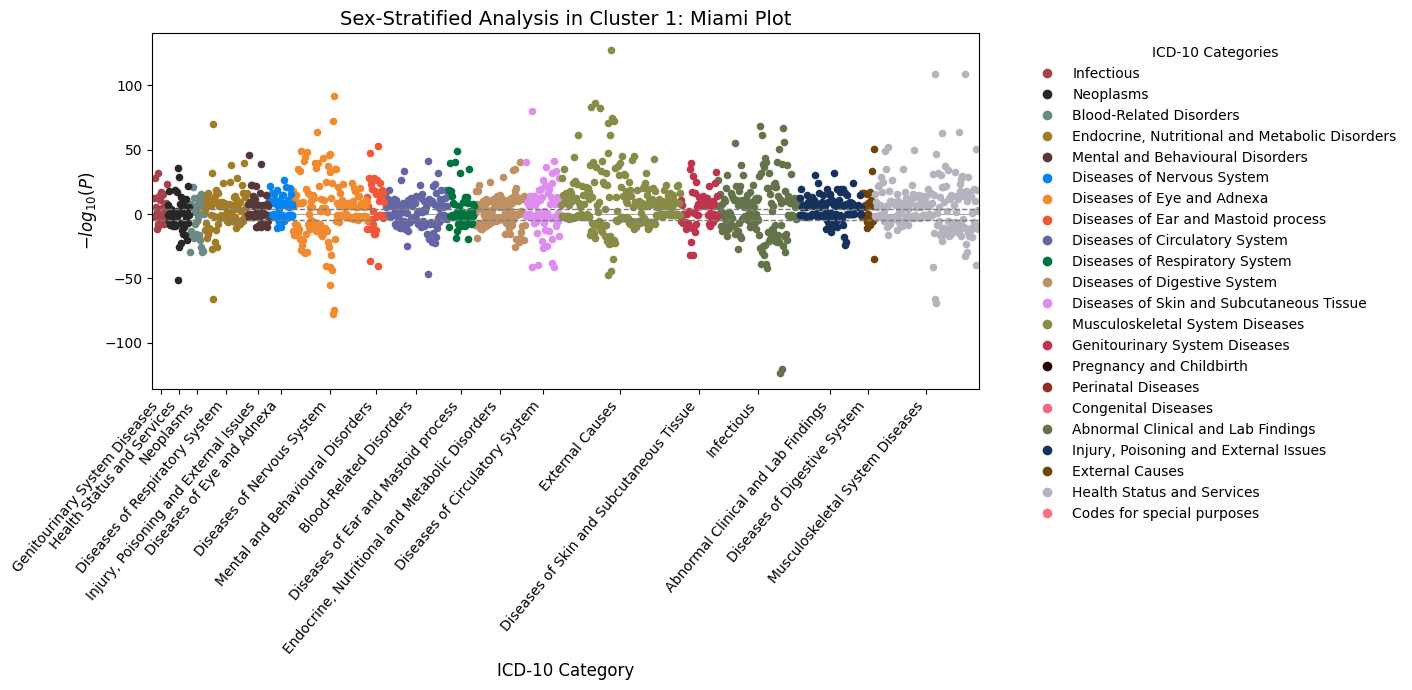

In [34]:
# Get the ordered list of ICD-10 categories based on their names
icd10order = list(map(ICDchapter_to_name, cluster['ICD10_chape'].explode().sort_values().unique()))

# Set figure dimensions
dims = (10, 7)
save = False
bc = .05 / cluster.shape[0]  # Bonferroni correction threshold

# Generate the Miami plot
fig, ax = plt.subplots(figsize=dims)
xlabels = []
xticks = []

# Dictionary to store legend handles
legend_handles = {}

# Plot data for each ICD-10 category
for label, df1 in cluster.explode('ICD10_chape_name').groupby('ICD10_chape_name'):
    # Get custom color for the category
    color = category_color_mapping.get(label, '#000000')
    
    # Scatter plot for female data
    scatter_f = ax.scatter(df1['ind'], df1['-log_pvalue_f'], color=color, s=20, label=label)
    
    # Scatter plot for male data (negative log P-values for Miami plot symmetry)
    scatter_m = ax.scatter(df1['ind'], -df1['-log_pvalue_m'], color=color, s=20)
    
    # Store legend handles (only keep one per category)
    if label not in legend_handles:
        legend_handles[label] = scatter_f

    # Store x-axis labels and their positions
    df1_max_ind = df1['ind'].iloc[-1]
    df1_min_ind = df1['ind'].iloc[0]
    xlabels.append(label)
    xticks.append((df1_max_ind - (df1_max_ind - df1_min_ind) / 2))

# Set x-axis tick positions and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=50, ha='right', fontsize=10)

# Add reference lines
ax.axhline(y=0, color='#7d7d7d', linewidth=0.5, zorder=0)  # Central horizontal line
ax.axhline(y=np.log10(bc), linestyle='--', color='#7d7d7d', linewidth=1)  # Bonferroni threshold (female)
ax.axhline(y=-np.log10(bc), linestyle='--', color='#7d7d7d', linewidth=1)  # Bonferroni threshold (male)

# Set axis labels and title
ax.set_xlabel('ICD-10 Category', fontsize=12)
ax.set_ylabel(r'$-log_{10}(P)$', fontsize=12)
ax.set_title("Sex-Stratified Analysis in Cluster 1: Miami Plot", fontsize=14)

# Match x-axis labels with ICD-10 order from the bar plot
ax.set_xticklabels(icd10order, rotation=50, ha='right', fontsize=10)

# Adjust x-axis limits with padding on the right
ax.set_xlim([-2, cluster['ind'].max() + 2])  

# Optimize layout to prevent overlap
plt.tight_layout()

# Add legend for ICD-10 categories outside the plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label) 
           for label, color in category_color_mapping.items()]
ax.legend(handles=handles, title="ICD-10 Categories", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=False)

# Save and display the plot
plt.savefig("Figures/MiamiPlot_Cluster1.pdf", dpi=600, format="pdf", bbox_inches="tight")
plt.show()
